In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Installing and importing necessary libraries

In [2]:
!pip install pydicom matplotlib numpy pandas sklearn tensorflow

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [3]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2024-09-16 19:12:11.587903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 19:12:11.588033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 19:12:11.725509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import numpy as np
import pydicom
from skimage.transform import resize

def load_dicom_images(folder_path, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.dcm'):
            dicom_path = os.path.join(folder_path, filename)
            dicom = pydicom.dcmread(dicom_path)
            image = dicom.pixel_array
            
            # Resize the image to the target size
            image_resized = resize(image, target_size, anti_aliasing=True, mode='reflect')
            
            images.append(image_resized)
    
    return np.array(images)

# Load and resize images
true_images = load_dicom_images('/kaggle/input/true-dataset-2')
false_images = load_dicom_images('/kaggle/input/false-dataset-2')

print("Number of significant cancer images:", len(true_images))
print("Number of non-significant cancer images:", len(false_images))

# Normalize pixel values
true_images = true_images / true_images.max()
false_images = false_images / false_images.max()

print("Shape of true_images:", true_images.shape)
print("Shape of false_images:", false_images.shape)

Number of significant cancer images: 1008
Number of non-significant cancer images: 1012
Shape of true_images: (1008, 256, 256)
Shape of false_images: (1012, 256, 256)


#  Loading and preprocessing the data:

# Visualizing sample images

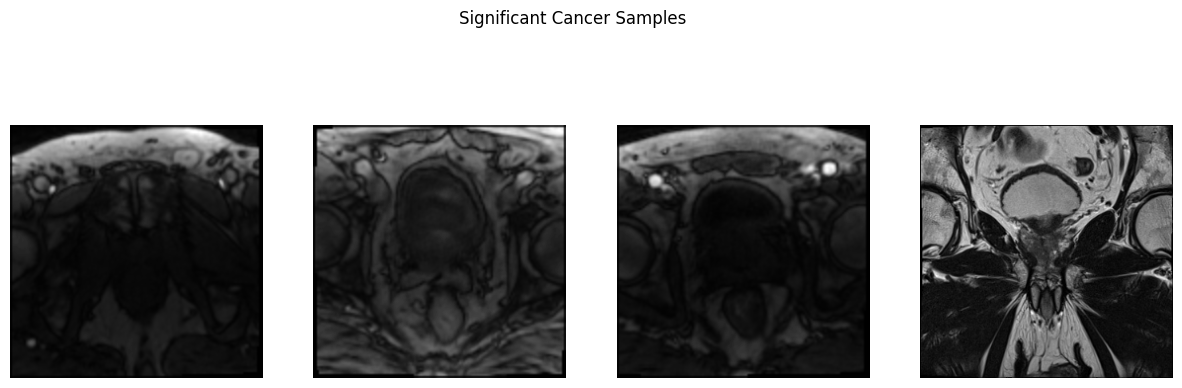

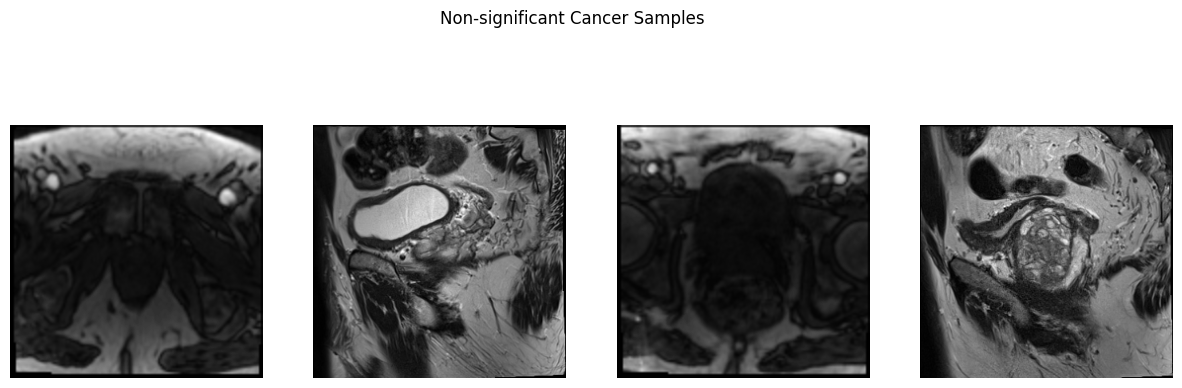

In [5]:
def plot_sample_images(images, title):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

plot_sample_images(true_images, "Significant Cancer Samples")
plot_sample_images(false_images, "Non-significant Cancer Samples")

New shape of true_images: (1008, 256, 256, 1)
New shape of false_images: (1012, 256, 256, 1)


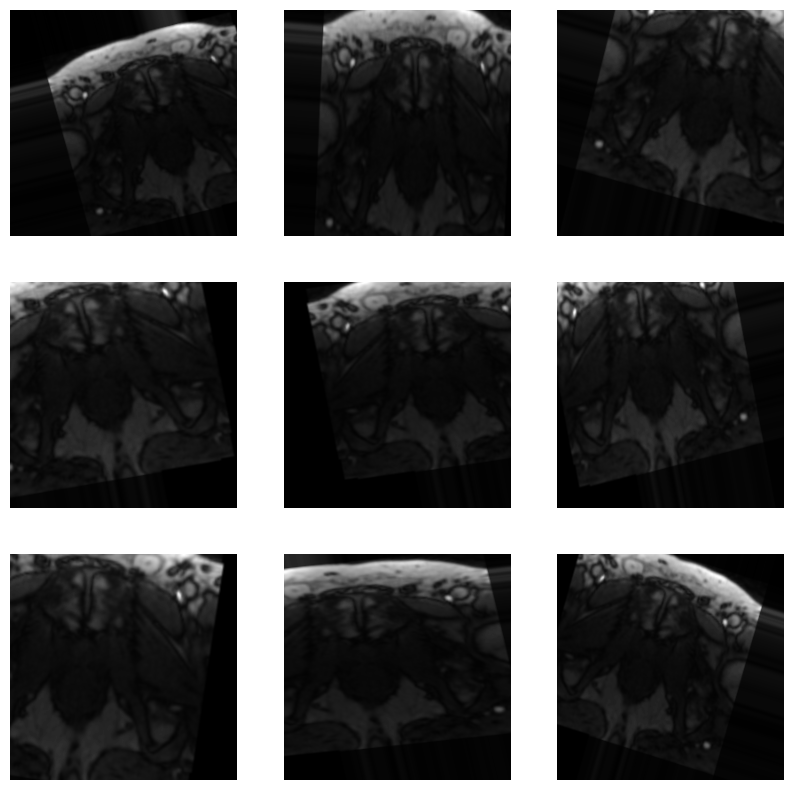

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming true_images and false_images are already loaded and normalized

# Add channel dimension to the images
true_images = np.expand_dims(true_images, axis=-1)
false_images = np.expand_dims(false_images, axis=-1)

print("New shape of true_images:", true_images.shape)
print("New shape of false_images:", false_images.shape)

# Augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example of applying augmentation to an image
sample_image = true_images[0]
sample_image = np.expand_dims(sample_image, 0)  # Add batch dimension
aug_iter = datagen.flow(sample_image)

# Plot some augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    aug_image = next(aug_iter)[0]
    plt.imshow(aug_image[:,:,0], cmap='gray')  # Use cmap='gray' for single-channel images
    plt.axis('off')
plt.show()

#  applying the augmentation techniques to our entire dataset:

* Step 1: Convert Lists to Arrays
First, converting the lists of images (standardized_healthy_images and standardized_not_healthy_images) to NumPy arrays.

* Step 2: Creating an ImageDataGenerator
Using the ImageDataGenerator to define the augmentation parameters.

* Step 3: Generate Augmented Images
Generate augmented images using the flow method from ImageDataGenerator.

Dataset shape: (2020, 64, 64, 1)
Labels shape: (2020,)


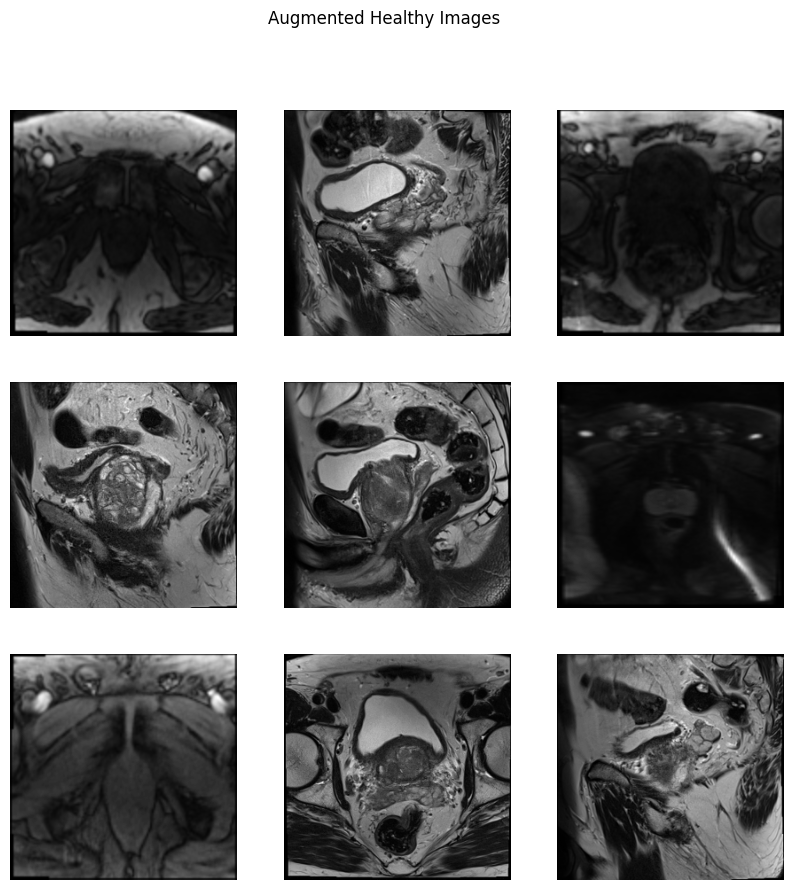

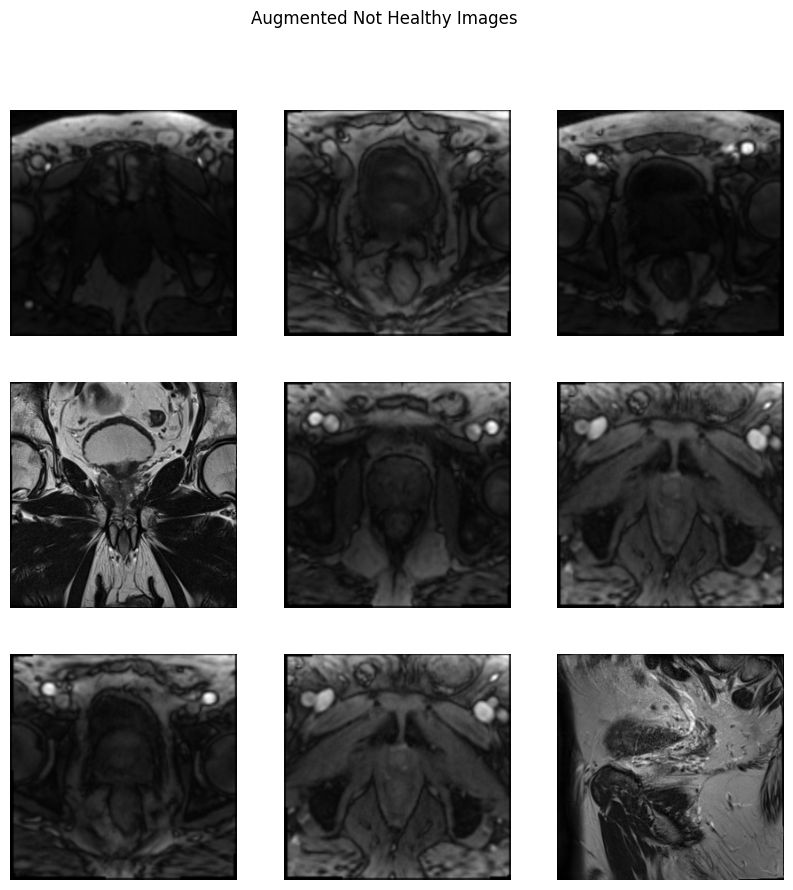

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# # Assuming true_images and false_images are already loaded and normalized
# # If not, load them using your previous code

# # Add channel dimension if not already present
# if true_images.ndim == 3:
#     true_images = np.expand_dims(true_images, axis=-1)
# if false_images.ndim == 3:
#     false_images = np.expand_dims(false_images, axis=-1)

# # Define the augmentation parameters
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Helper function to augment images and store them
# def augment_images(images_array, datagen, batch_size=32):
#     augmented_images = []
#     # Create an iterator
#     aug_iter = datagen.flow(images_array, batch_size=batch_size)
#     # Calculate number of batches needed
#     num_batches = len(images_array) // batch_size + int(len(images_array) % batch_size != 0)
    
#     for _ in range(num_batches):
#         aug_images_batch = next(aug_iter)
#         augmented_images.extend(aug_images_batch)
    
#     return np.array(augmented_images)

# Apply augmentation to true (healthy) and false (not healthy) datasets
not_healthy_images = true_images
healthy_images = false_images

# Define variables for labels and dataset
labels = []
dataset = []

# Image size
image_size = (64, 64)

# Preprocess augmented unhealthy images and append them to the dataset
for image in not_healthy_images:
    # Resize the image
    image = Image.fromarray((image[:,:,0] * 255).astype('uint8'), 'L')
    image = image.resize(image_size)
    dataset.append(np.array(image))
    labels.append(0)

# Preprocess augmented healthy images and append them to the dataset
for image in healthy_images:
    # Resize the image
    image = Image.fromarray((image[:,:,0] * 255).astype('uint8'), 'L')
    image = image.resize(image_size)
    dataset.append(np.array(image))
    labels.append(1)

# Convert dataset and labels to NumPy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Reshape dataset to include channel dimension
dataset = dataset.reshape(-1, 64, 64, 1)

# Shuffle the dataset
dataset, labels = shuffle(dataset, labels, random_state=42)

# Display the shapes of dataset and labels
print("Dataset shape:", dataset.shape)
print("Labels shape:", labels.shape)

# Display some augmented images for confirmation
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(healthy_images[i][:,:,0], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Healthy Images")
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(not_healthy_images[i][:,:,0], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Not Healthy Images")
plt.show()

**Okay so we have successfully preproccessed our images into numpy arrays. Now we are going to split it into training and test datasets using train_test_split before we start building our model. Okaay so lets get started now.**

In [8]:
from sklearn.model_selection import train_test_split

# Ensure labels is not empty and has consistent length
print("Dataset shape:", dataset.shape)
print("Labels shape:", labels.shape)

# Split datasets into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(
    dataset,
    labels, 
    test_size=0.2,
    random_state=42
)

# Display the shapes of the resulting splits
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)


Dataset shape: (2020, 64, 64, 1)
Labels shape: (2020,)
Training data shape: (1616, 64, 64, 1)
Test data shape: (404, 64, 64, 1)
Training labels shape: (1616,)
Test labels shape: (404,)


Okay so we have successfully been able to split our datasets into train and testing. Now we are going to normalize our dataset and start building our models. We will start by creating a base model and try to beat this base model. Okay so lets get started now.

# model_0
Build base model using keras functional API

In [9]:
import tensorflow as tf
#set random seed
tf.random.set_seed(42)

#Normalize x_train and x_test datasets
x_train = x_train / 255.0  # Note the .0 to ensure float division
x_test = x_test / 255.0

# #Define variables
# INPUT_SHAPE=3

INPUT_SHAPE = 1  # Change this to 1 for grayscale images
inputs = tf.keras.layers.Input(shape=(64, 64, INPUT_SHAPE))

#Build models
x = tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=10,
                           strides=1)(inputs)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1
)(x)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1
)(x)

#Flattern model
x = tf.keras.layers.Flatten()(x)

#Define output
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

#Define model
model_0 = tf.keras.Model(inputs, outputs)

In [10]:

#Check model layers
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 55, 55, 32)     │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43808)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        43,809 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,905 (984.00 KB)

 Trainable params: 251,905 (984.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:

#Compile model
model_0.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
   

In [12]:
#set random seed
tf.random.set_seed(42)

#Fit model
history_0 = model_0.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10
)

Epoch 1/10
18/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4799 - loss: 0.8770

I0000 00:00:1726513973.278656     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5047 - loss: 0.8436 - val_accuracy: 0.6064 - val_loss: 0.6494
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6880 - loss: 0.6056 - val_accuracy: 0.7921 - val_loss: 0.5335
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7991 - loss: 0.5130 - val_accuracy: 0.8342 - val_loss: 0.4285
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8308 - loss: 0.4620 - val_accuracy: 0.8515 - val_loss: 0.3754
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8740 - loss: 0.3462 - val_accuracy: 0.8738 - val_loss: 0.3875
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9014 - loss: 0.3170 - val_accuracy: 0.8738 - val_loss: 0.3580
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9087 - loss: 0.2989 - val_accuracy: 0.8985 - val_loss: 0.3663
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9421 - loss: 0.2004 - val_accuracy: 0.9208 - val_loss: 0.

In [13]:

#Evaluate our model
loss_0, accuracy_0 = model_0.evaluate(x_test, y_test)
loss_0, accuracy_0

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8761 - loss: 0.4422


(0.46736130118370056, 0.8836633563041687)

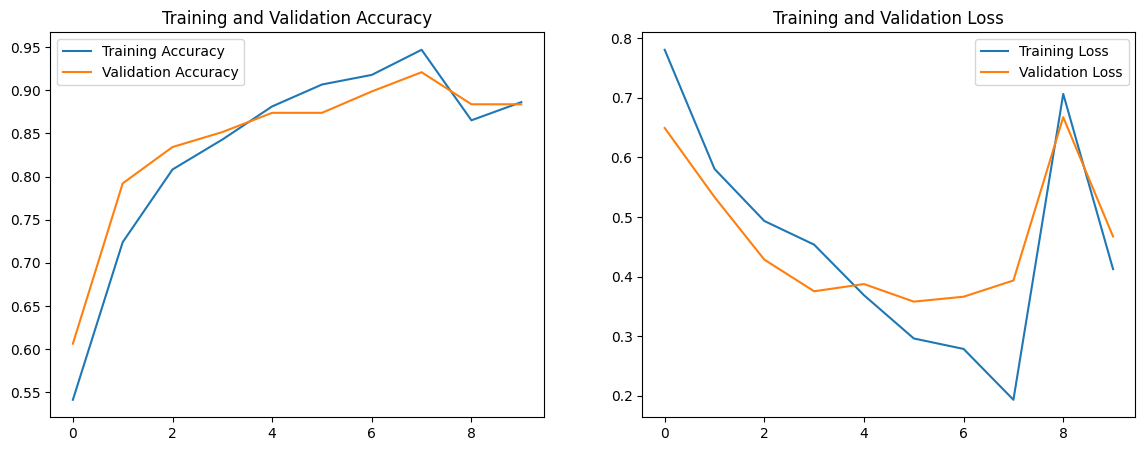

In [14]:
# Plotting the training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

# Call the plot function
plot_history(history_0)

Okay so our model is doing well on training dataset but not on our test datasets. This means that our model is totally overfiting. Okay so now that we have our baseline defined, we are going to build more models to see if we will be able to beat our base model. Okay so lets get started now to build our first model.

# model_1
With this model, we are going to introduct max polling layers in our base model hoping to get a better results than our base model. Okay so lets get started now.

In [15]:
#set random seed
tf.random.set_seed(42)

#Define input shape
INPUT_SHAPE = 1  # Change this to 1 for grayscale images
inputs = tf.keras.layers.Input(shape=(64, 64, INPUT_SHAPE))

#Define layers
x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1,
    padding="same"
)(inputs)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Define output layer
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

#Define model
model_1 = tf.keras.Model(inputs, outputs)
     

In [16]:
#Check model layers
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,129 (813.00 KB)

 Trainable params: 208,129 (813.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:

#Compile models
model_1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
     

#Set random seed
tf.random.set_seed(42)

#Fit on train datasets
history_1 = model_1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15
)
    

Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.5078 - loss: 0.7561 - val_accuracy: 0.5272 - val_loss: 0.6941
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4992 - loss: 0.6970 - val_accuracy: 0.5520 - val_loss: 0.6915
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5455 - loss: 0.6928 - val_accuracy: 0.5743 - val_loss: 0.6903
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5497 - loss: 0.6912 - val_accuracy: 0.5421 - val_loss: 0.6846
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5362 - loss: 0.6894 - val_accuracy: 0.6634 - val_loss: 0.6708
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5725 - loss: 0.6635 - val_accuracy: 0.6708 - val_loss: 0.6417
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6944 - loss: 0.6135 - val_accuracy: 0.6881 - val_loss: 0.6038
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7113 - loss: 0.5776 - val_accuracy: 0.7178 - val_loss

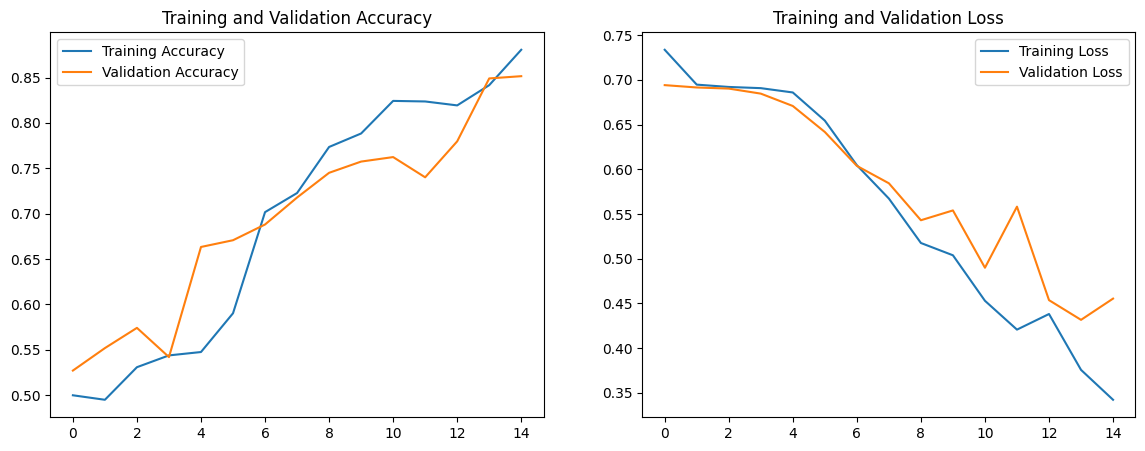

In [18]:
# Call the plot function
plot_history(history_1)

In [19]:
#Evaluate model
loss_1, accuracy_1 = model_1.evaluate(x_test, y_test)
loss_1, accuracy_1

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8857 - loss: 0.4368 


(0.45538872480392456, 0.8514851331710815)

# model_2
Okay so we are going to build our 3rd model. With this model, we are going to add two more layers to above layers making 5 conv2D layer and also increase the total number of layers. Okay so lets get started now.

In [20]:
#Set random seed
tf.random.set_seed(42)

#Define input shape
INPUT_SHAPE = 1  # Change this to 1 for grayscale images
inputs = tf.keras.layers.Input(shape=(64, 64, INPUT_SHAPE))

#Define layers
x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=3,
    strides=1,
    padding="same"
)(inputs)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

# Add Global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Add output layer
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

#Add model layer
model_2 = tf.keras.Model(inputs, outputs)
     

#Check models layer
model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 100)    │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 100)    │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 100)    │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 100)      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 100)      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 100)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,001,501 (15.26 MB)

 Trainable params: 4,001,501 (15.26 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#Compile model
model_2.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
     

#Set random seed
tf.random.set_seed(42)

#Fit on train datasets
history_2 = model_2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20
)

Epoch 1/20


2024-09-16 19:13:20.311591: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[100,100,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,100,33,33]{3,2,1,0}, f32[32,100,32,32]{3,2,1,0}), window={size=10x10 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-16 19:13:20.534631: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.22314524s
Trying algorithm eng0{} for conv (f32[100,100,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,100,33,33]{3,2,1,0}, f32[32,100,32,32]{3,2,1,0}), window={size=10x10 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-16 19:13:22.191543: E ex

51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.4895 - loss: 1.9493 - val_accuracy: 0.5223 - val_loss: 0.6987
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4773 - loss: 0.7217 - val_accuracy: 0.5446 - val_loss: 0.6929
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5314 - loss: 0.6960 - val_accuracy: 0.5297 - val_loss: 0.6913
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5542 - loss: 0.6897 - val_accuracy: 0.5743 - val_loss: 0.6836
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5403 - loss: 0.6844 - val_accuracy: 0.5594 - val_loss: 0.6822
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5537 - loss: 0.6884 - val_accuracy: 0.6015 - val_loss: 0.6211
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6270 - loss: 0.6458 - val_accuracy: 0.6980 - val_loss: 0.5783
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7218 - loss: 0.5196 - val_accuracy: 0.7550 - val_loss: 

In [22]:
#Evaluate model
loss_2, accuracy_2 = model_2.evaluate(x_test, y_test)
loss_2, accuracy_2

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9842 - loss: 0.0691


(0.09778139740228653, 0.9801980257034302)

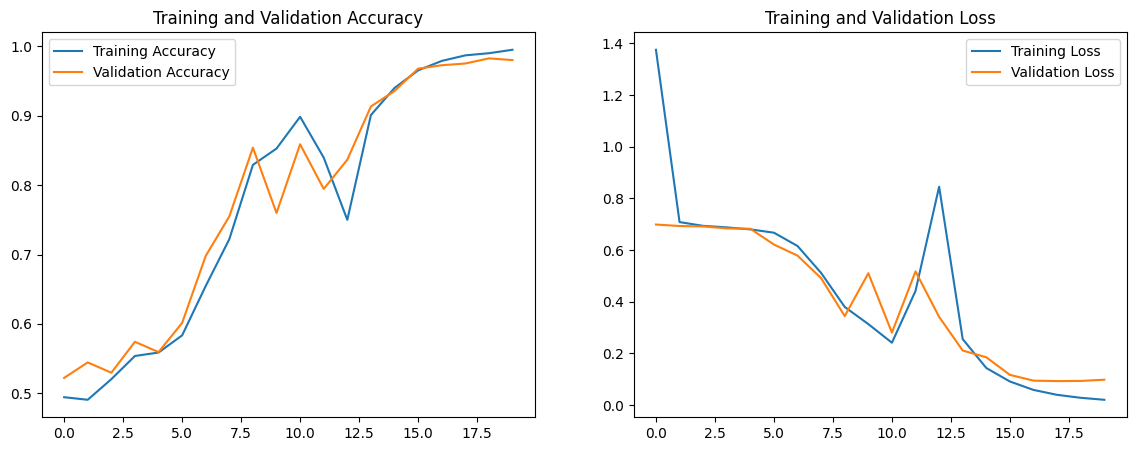

In [23]:
# Call the plot function
plot_history(history_2)

# model_3
Okay so from above, we can see that our model is doing well. But we have to try to reduce the loss value. With the 3rd model that we are going to create, we are going to clone model_2 and increase the total number of epochs from 15 to 30.

In [24]:
#Set random seed
tf.random.set_seed(42)

#Clone model_2 as model_3
model_3 = tf.keras.models.clone_model(model_2)

#Compile model_3
model_3.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
     

#set random seed
tf.random.set_seed(42)

#Fit on train datasets
history_3 = model_3.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30
)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.4887 - loss: 1.8014 - val_accuracy: 0.4728 - val_loss: 0.7005
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5092 - loss: 0.6924 - val_accuracy: 0.4901 - val_loss: 0.6928
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5155 - loss: 0.6927 - val_accuracy: 0.5322 - val_loss: 0.6912
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5527 - loss: 0.6900 - val_accuracy: 0.5594 - val_loss: 0.6878
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5585 - loss: 0.6881 - val_accuracy: 0.5470 - val_loss: 0.6759
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5678 - loss: 0.6805 - val_accuracy: 0.5520 - val_loss: 0.6712
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6116 - loss: 0.6741 - val_accuracy: 0.6361 - val_loss: 0.6013
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6735 - loss: 0.5799 - val_accuracy: 0.7847 - v

In [25]:
#Evaluate our model
loss_3, accuracy_3 = model_3.evaluate(x_test, y_test)
loss_3, accuracy_3

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7518 - loss: 0.5839


(0.6221739649772644, 0.7301980257034302)

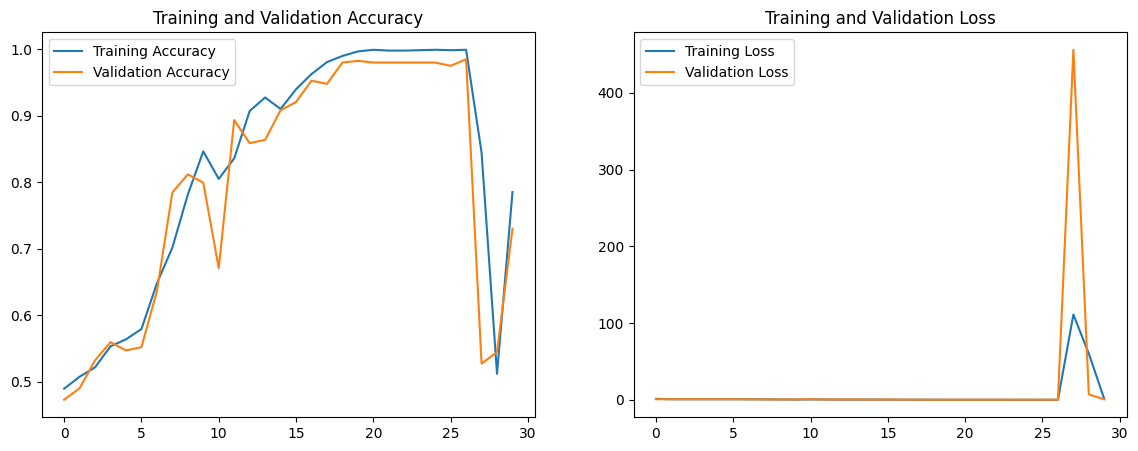

In [26]:
# Call the plot function
plot_history(history_3)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


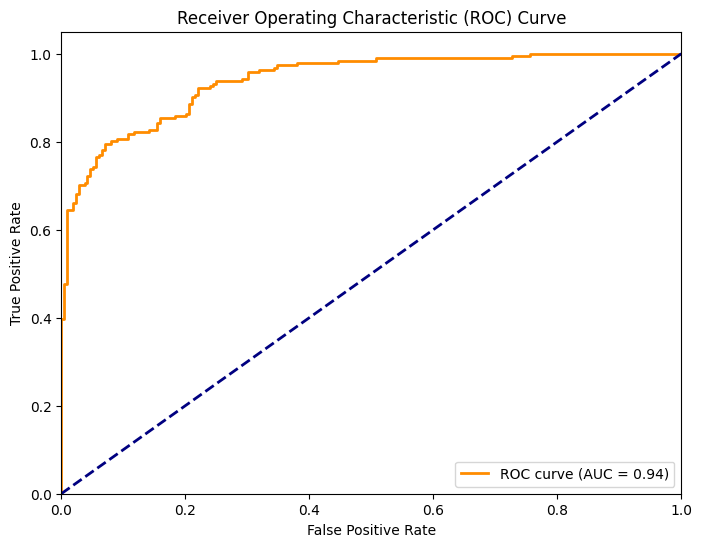

AUC: 0.94


In [27]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model_5 is your trained model
# Generate predictions on the test set
y_pred = model_3.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print(f'AUC: {roc_auc:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


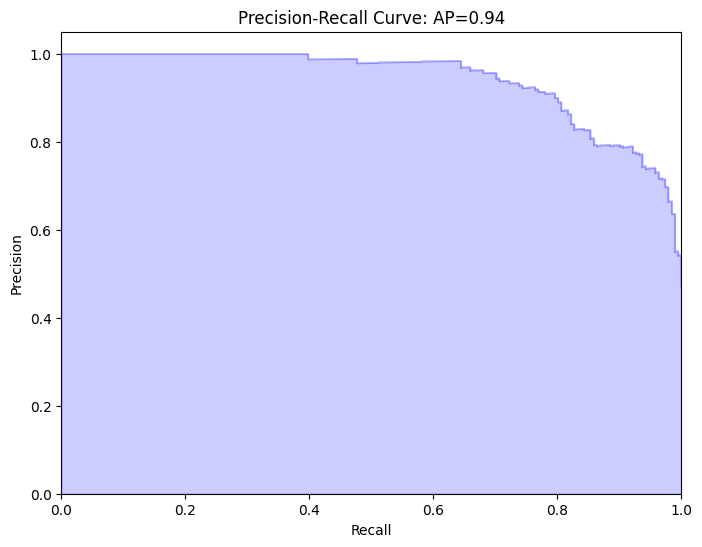

Average Precision: 0.94


In [28]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming model_5 is your trained model and x_test, y_test are your test data
y_pred = model_3.predict(x_test)

# Compute Precision-Recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
plt.show()

print(f'Average Precision: {average_precision:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


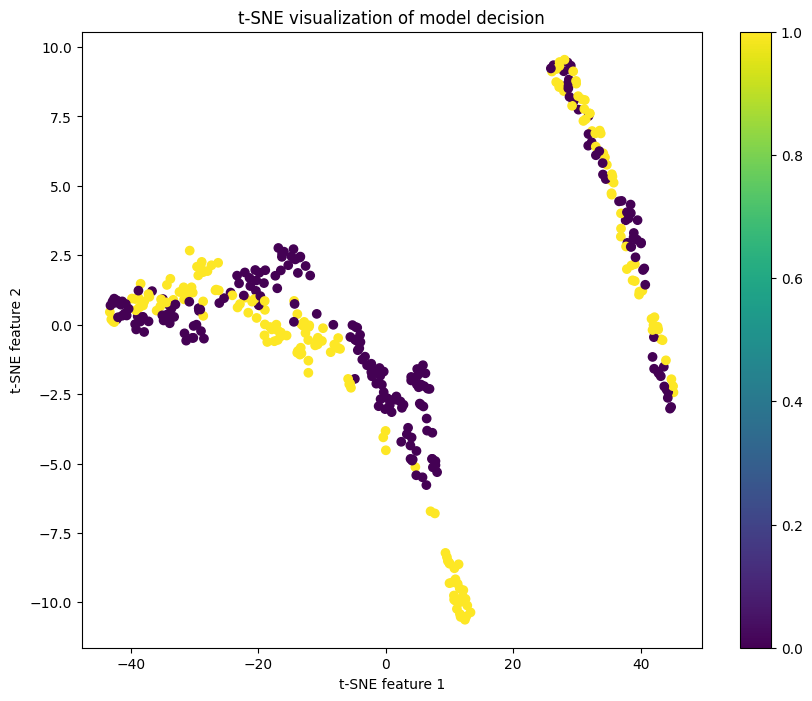

In [29]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming model_3 is your trained model and x_test, y_test are your test data
# We'll use the last layer before the output as our feature representation
feature_model = tf.keras.Model(inputs=model_3.input, 
                               outputs=model_3.layers[-2].output)
features = feature_model.predict(x_test)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Create the plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test, cmap='viridis')
plt.colorbar(scatter)

plt.title('t-SNE visualization of model decision')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


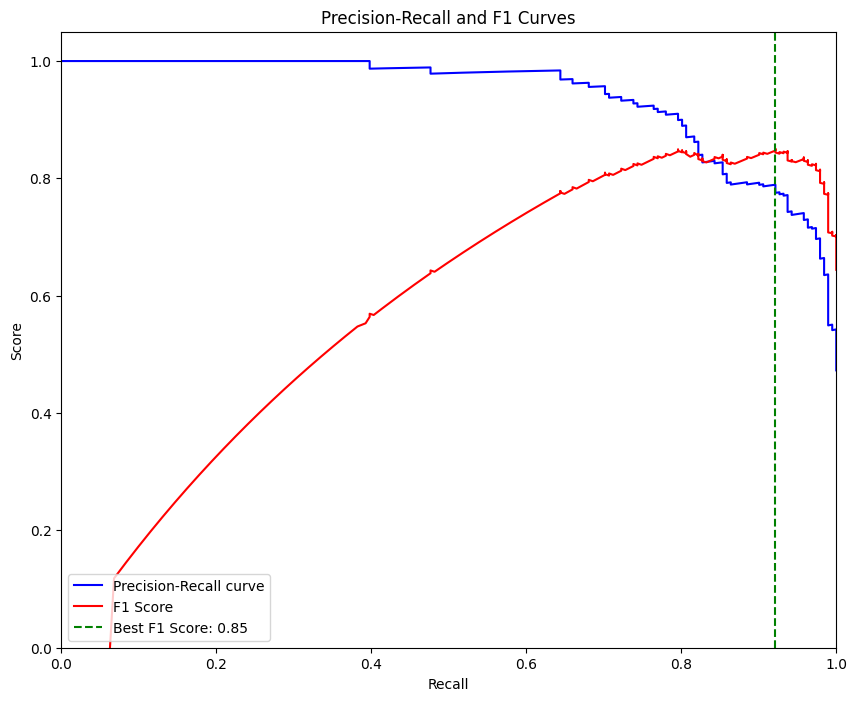

Average Precision: 0.94
Best F1 Score: 0.85 at threshold 0.06
F1 Score at 0.5 threshold: 0.60


In [30]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

# Assuming model_3 is your trained model and x_test, y_test are your test data
y_pred_proba = model_3.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute Precision-Recall curve and average precision score
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Calculate F1 scores for different thresholds
f1_scores = [f1_score(y_test, (y_pred_proba > t).astype(int)) for t in thresholds]

# Find the best F1 score and corresponding threshold
best_f1_score = max(f1_scores)
best_threshold = thresholds[f1_scores.index(best_f1_score)]

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.plot(recall[:-1], f1_scores, color='r', label='F1 Score')
plt.axvline(x=recall[f1_scores.index(best_f1_score)], color='g', linestyle='--', label=f'Best F1 Score: {best_f1_score:.2f}')

plt.xlabel('Recall')
plt.ylabel('Score')
plt.title('Precision-Recall and F1 Curves')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.show()

print(f'Average Precision: {average_precision:.2f}')
print(f'Best F1 Score: {best_f1_score:.2f} at threshold {best_threshold:.2f}')
print(f'F1 Score at 0.5 threshold: {f1_score(y_test, y_pred):.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


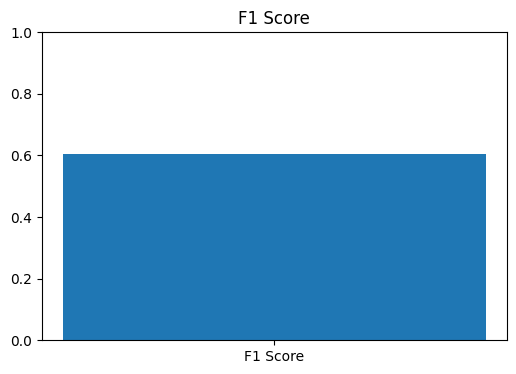

F1 Score: 0.6036


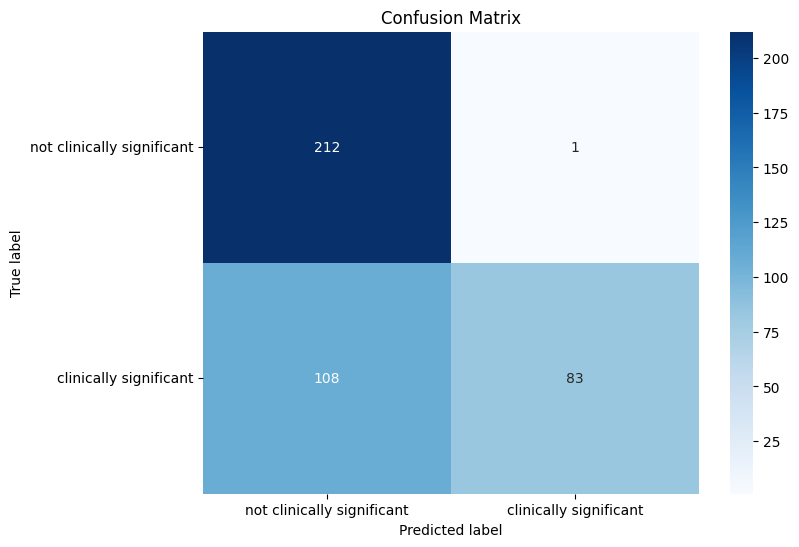

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on the test set
y_pred = model_3.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot F1 score
plt.figure(figsize=(6, 4))
plt.bar(['F1 Score'], [f1])
plt.ylim(0, 1)
plt.title('F1 Score')
plt.show()
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Set custom labels for the confusion matrix
labels = ['not clinically significant', 'clinically significant']
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels, rotation=0)

plt.show()

# SVM

Dataset shape: (2020, 64, 64, 1)
Labels shape: (2020,)


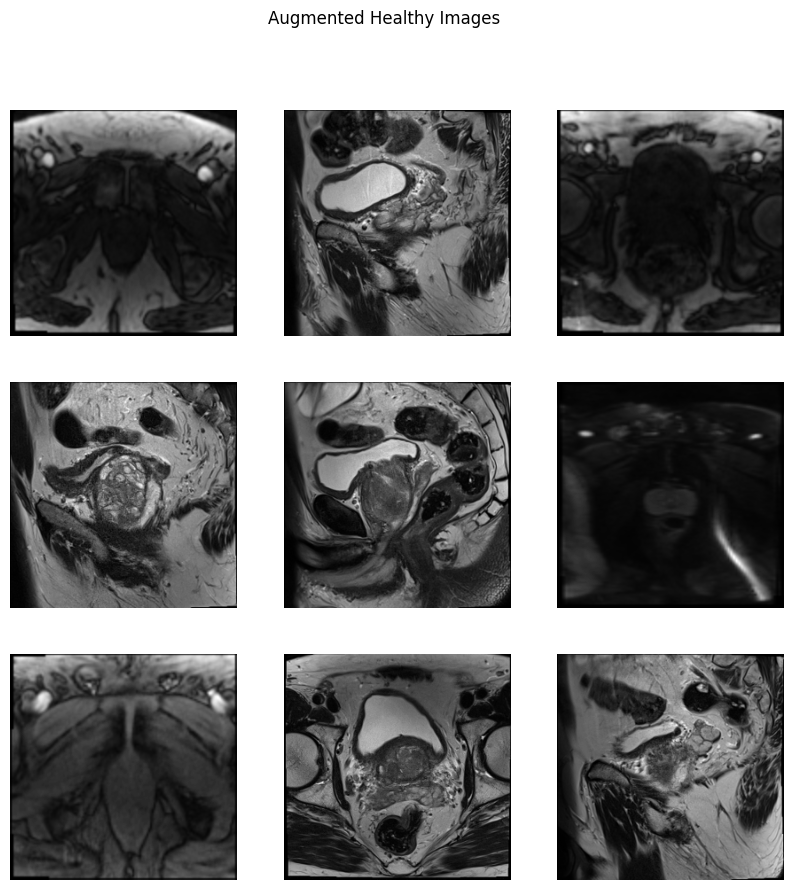

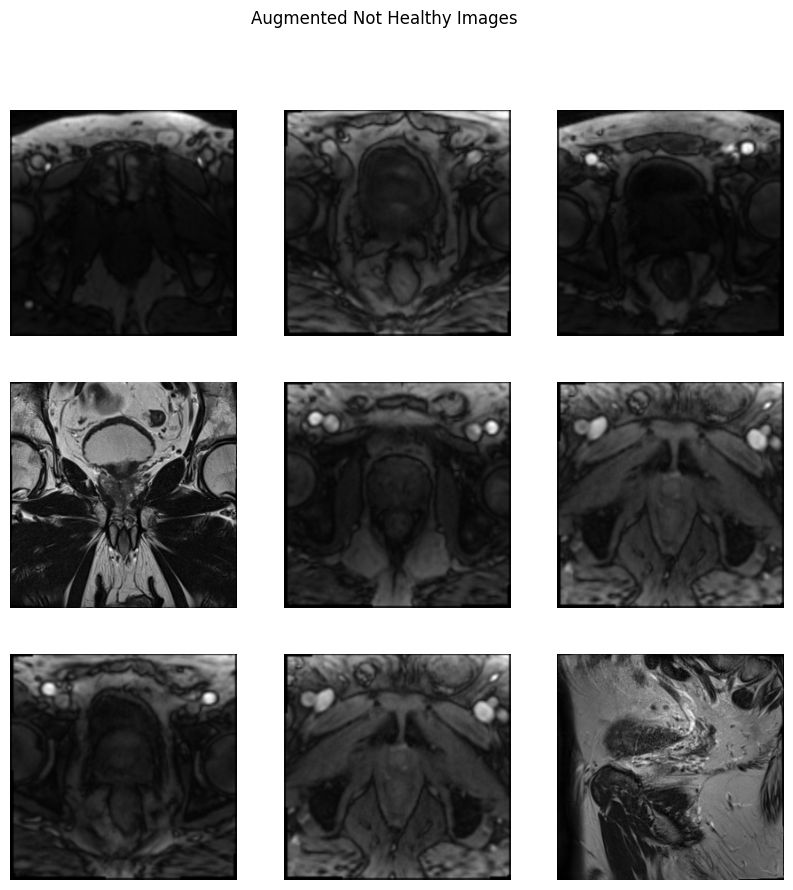

In [32]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from PIL import Image
# import matplotlib.pyplot as plt
# from sklearn.utils import shuffle

# # Assuming true_images and false_images are already loaded and normalized
# # If not, load them using your previous code

# # Add channel dimension if not already present
# if true_images.ndim == 3:
#     true_images = np.expand_dims(true_images, axis=-1)
# if false_images.ndim == 3:
#     false_images = np.expand_dims(false_images, axis=-1)

# # Define the augmentation parameters
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Helper function to augment images and store them
# def augment_images(images_array, datagen, batch_size=32):
#     augmented_images = []
#     # Create an iterator
#     aug_iter = datagen.flow(images_array, batch_size=batch_size)
#     # Calculate number of batches needed
#     num_batches = len(images_array) // batch_size + int(len(images_array) % batch_size != 0)
    
#     for _ in range(num_batches):
#         aug_images_batch = next(aug_iter)
#         augmented_images.extend(aug_images_batch)
    
#     return np.array(augmented_images)

# Apply augmentation to true (healthy) and false (not healthy) datasets
not_healthy_images = true_images
healthy_images = false_images

# Define variables for labels and dataset
labels = []
dataset = []

# Image size
image_size = (64, 64)

# Preprocess augmented unhealthy images and append them to the dataset
for image in not_healthy_images:
    # Resize the image
    image = Image.fromarray((image[:,:,0] * 255).astype('uint8'), 'L')
    image = image.resize(image_size)
    dataset.append(np.array(image))
    labels.append(0)

# Preprocess augmented healthy images and append them to the dataset
for image in healthy_images:
    # Resize the image
    image = Image.fromarray((image[:,:,0] * 255).astype('uint8'), 'L')
    image = image.resize(image_size)
    dataset.append(np.array(image))
    labels.append(1)

# Convert dataset and labels to NumPy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Reshape dataset to include channel dimension
dataset = dataset.reshape(-1, 64, 64, 1)

# Shuffle the dataset
dataset, labels = shuffle(dataset, labels, random_state=42)

# Display the shapes of dataset and labels
print("Dataset shape:", dataset.shape)
print("Labels shape:", labels.shape)

# Display some augmented images for confirmation
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(healthy_images[i][:,:,0], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Healthy Images")
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(not_healthy_images[i][:,:,0], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Not Healthy Images")
plt.show()

In [33]:
print("Dataset length:", len(dataset))
print("Labels length:", len(labels))

Dataset length: 2020
Labels length: 2020


In [34]:
# Convert dataset and labels to NumPy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Reshape dataset to include channel dimension
dataset = dataset.reshape(-1, 64, 64, 1)

# Shuffle the dataset
dataset, labels = shuffle(dataset, labels, random_state=42)

# Ensure labels is a NumPy array
if isinstance(labels, list):
    labels = np.array(labels)

# Display the shapes of dataset and labels
print("Dataset shape:", dataset.shape)
print("Labels shape:", labels.shape)

Dataset shape: (2020, 64, 64, 1)
Labels shape: (2020,)


In [35]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the images
X = dataset.reshape(dataset.shape[0], -1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)



In [36]:
# Assuming your original image size was 64x64x1
image = X_train[0].reshape(64, 64, 1)

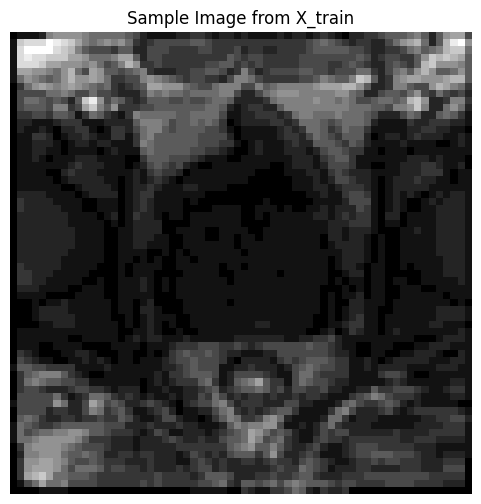

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Sample Image from X_train')
plt.show()

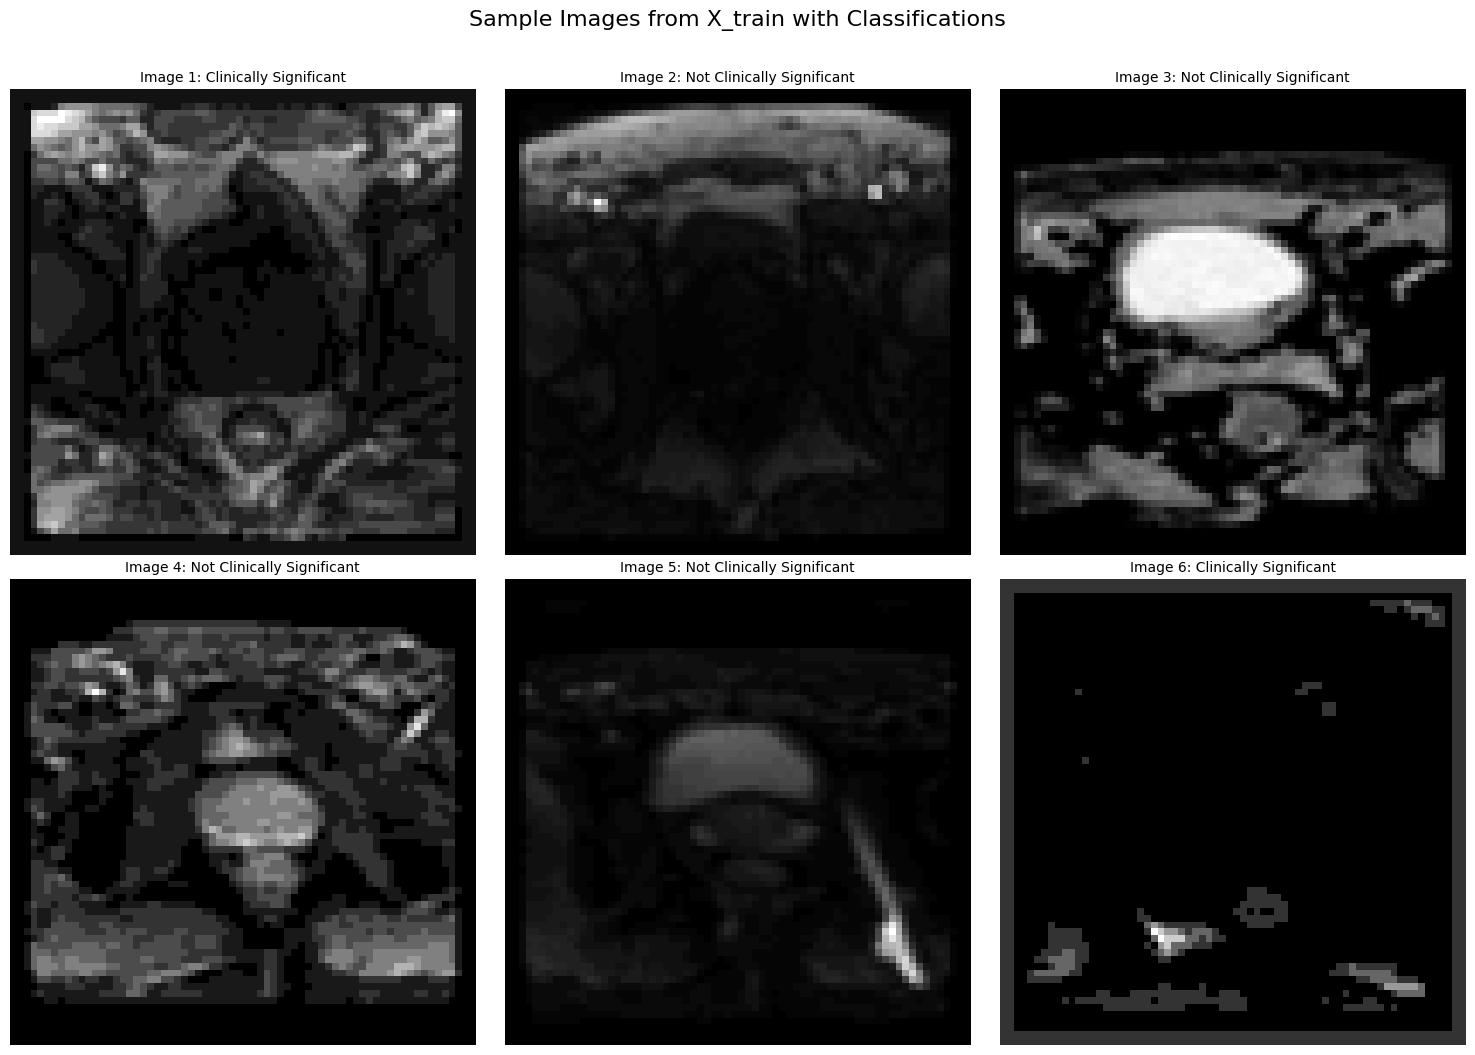

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(X_train, y_train, num_images=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(num_images):
        image = X_train[i].reshape(64, 64, 1)
        
        # Create a color border based on the label
        bordered_image = np.pad(image, ((2,2), (2,2), (0,0)), mode='constant', 
                                constant_values=1 if y_train[i] == 1 else 0)
        
        axes[i].imshow(bordered_image, cmap='gray')
        axes[i].axis('off')
        
        label = "Clinically Significant" if y_train[i] == 1 else "Not Clinically Significant"
        axes[i].set_title(f'Image {i+1}: {label}', fontsize=10, pad=5)
        
        # Add a colored border to the subplot
        for spine in axes[i].spines.values():
            spine.set_edgecolor('green' if y_train[i] == 1 else 'red')
            spine.set_linewidth(2)

    plt.tight_layout()
    plt.suptitle("Sample Images from X_train with Classifications", fontsize=16, y=1.05)
    plt.show()

# Usage
plot_images(X_train, y_train)

Accuracy: 0.7995
F1 Score: 0.8235


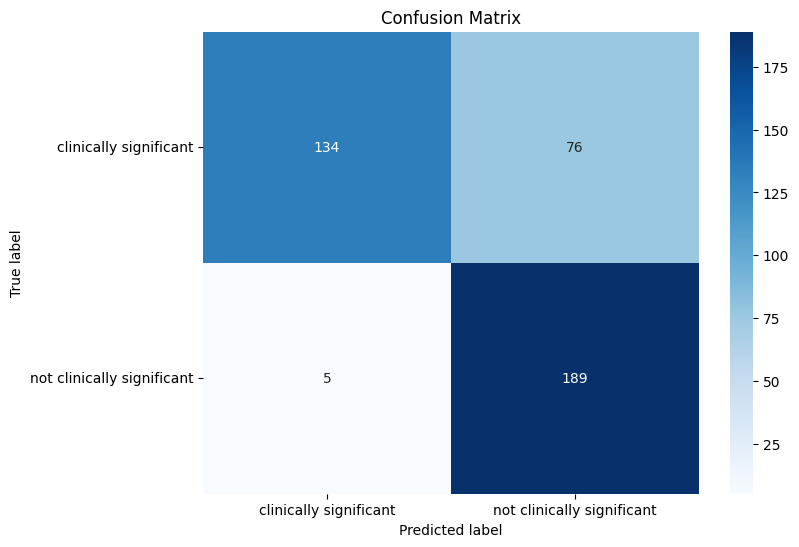

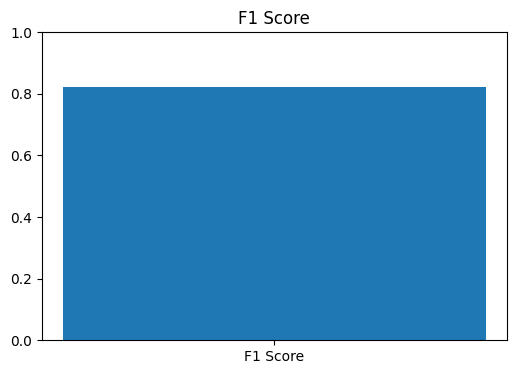

In [39]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Create and train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Set custom labels for the confusion matrix
labels = ['clinically significant', 'not clinically significant']
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels, rotation=0)

plt.show()

# Plot F1 score
plt.figure(figsize=(6, 4))
plt.bar(['F1 Score'], [f1])
plt.ylim(0, 1)
plt.title('F1 Score')
plt.show()

# IMPROVED SVM

In [40]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingClassifier

# Feature Selection
selector = SelectKBest(f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Hyperparameter Tuning with Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_

# Ensemble Method: Voting Classifier
svm1 = SVC(probability=True, random_state=42, **grid_search.best_params_)
svm2 = SVC(probability=True, random_state=43, **grid_search.best_params_)
svm3 = SVC(probability=True, random_state=44, **grid_search.best_params_)

ensemble_model = VotingClassifier(
    estimators=[('svm1', svm1), ('svm2', svm2), ('svm3', svm3)],
    voting='soft'
)

ensemble_model.fit(X_train_scaled, y_train)

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


VotingClassifier(estimators=[('svm1',
                              SVC(C=10, gamma='auto', probability=True,
                                  random_state=42)),
                             ('svm2',
                              SVC(C=10, gamma='auto', probability=True,
                                  random_state=43)),
                             ('svm3',
                              SVC(C=10, gamma='auto', probability=True,
                                  random_state=44))],
                 voting='soft')

Best SVM Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Training Accuracy: 0.9851
Test Accuracy: 0.9455
Test Precision: 0.9467
Test F1 Score: 0.9456

Probabilities for the first 5 test samples:
Sample 1: [3.97399704e-12 1.00000000e+00]
Sample 2: [0.97298475 0.02701525]
Sample 3: [9.99946608e-01 5.33919185e-05]
Sample 4: [9.99655344e-01 3.44656109e-04]
Sample 5: [9.99998910e-01 1.08977321e-06]

ROC AUC: 0.9855


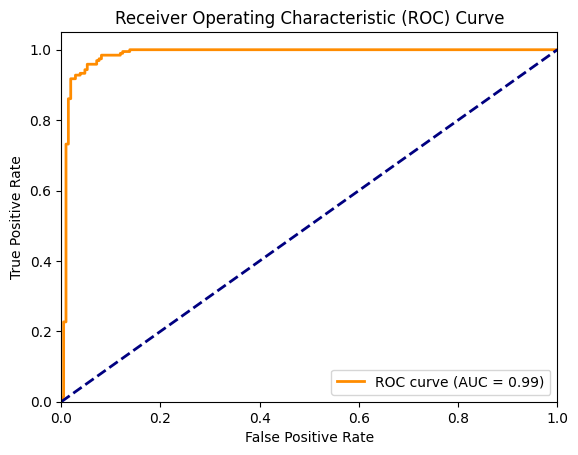

In [41]:


# Calculate training accuracy and probabilities
y_train_pred = ensemble_model.predict(X_train_scaled)
y_train_pred_proba = ensemble_model.predict_proba(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate test accuracy, precision, and probabilities
y_test_pred = ensemble_model.predict(X_test_scaled)
y_test_pred_proba = ensemble_model.predict_proba(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the results
print(f"Best SVM Parameters: {grid_search.best_params_}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Print probabilities for the first few test samples
print("\nProbabilities for the first 5 test samples:")
for i in range(min(5, len(y_test_pred_proba))):
    print(f"Sample {i+1}: {y_test_pred_proba[i]}")

# If it's a binary classification problem, you can also calculate ROC AUC
if y_test_pred_proba.shape[1] == 2:
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"\nROC AUC: {roc_auc:.4f}")

# Optional: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
# # Make predictions
# y_pred = ensemble_model.predict(X_test_scaled)

# # Calculate accuracy and F1 score
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print(f"Best SVM Parameters: {grid_search.best_params_}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"F1 Score: {f1:.4f}")

In [43]:
# # Make predictions
# y_pred = ensemble_model.predict(X_test_scaled)

# # Calculate accuracy and F1 score
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print(f"Best SVM Parameters: {grid_search.best_params_}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"F1 Score: {f1:.4f}")

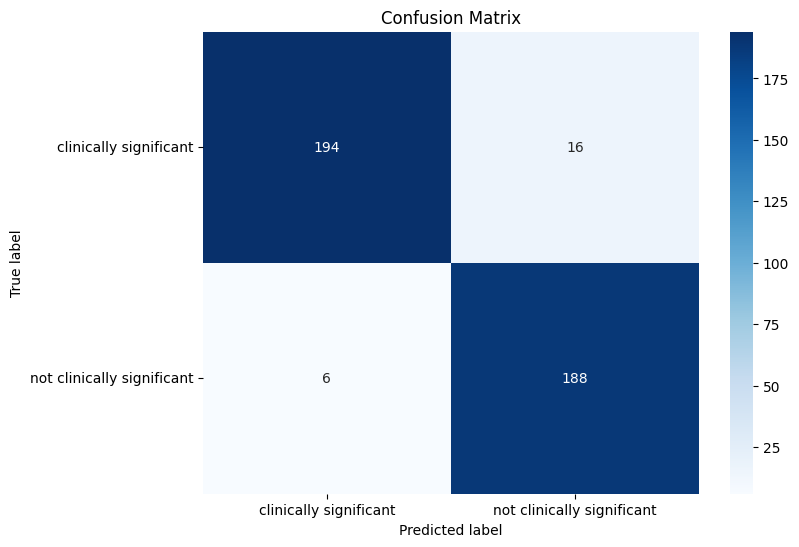

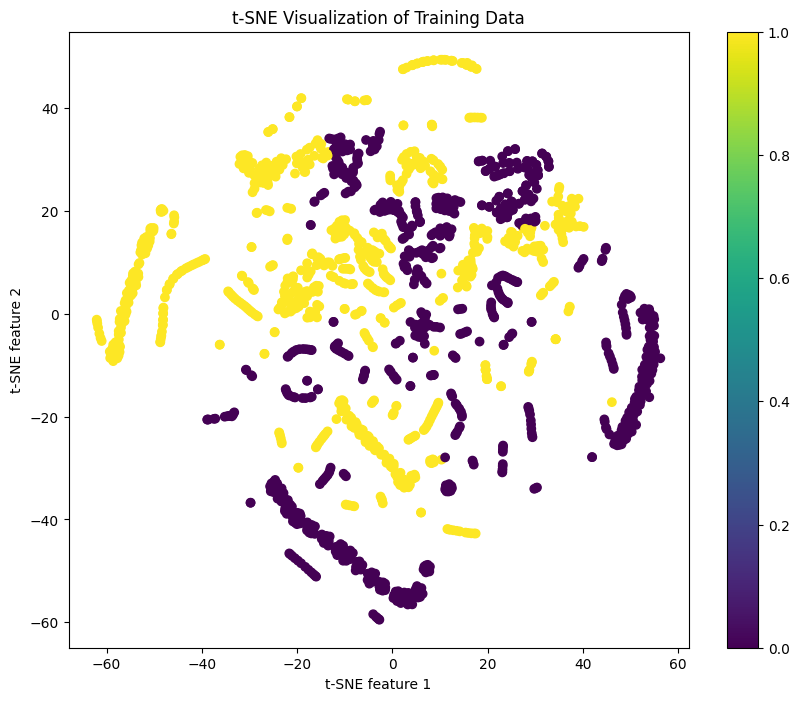

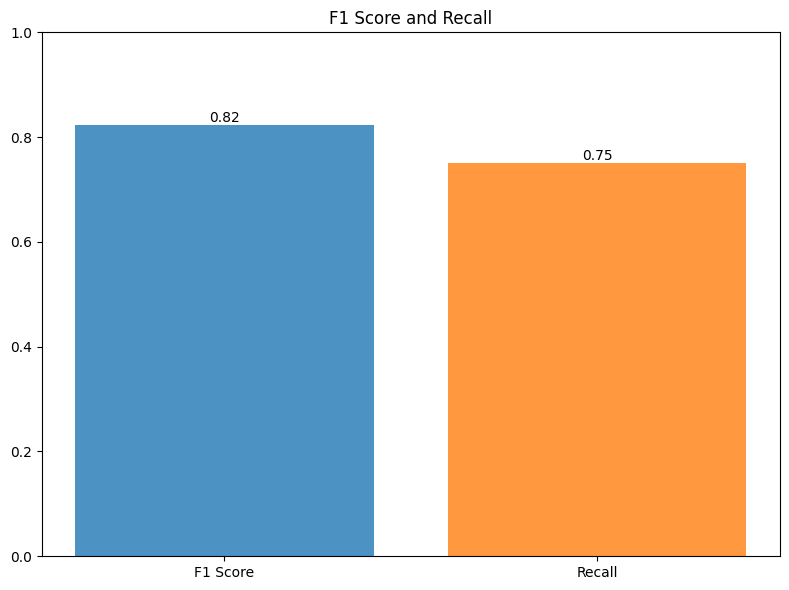

In [44]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
labels = ['clinically significant', 'not clinically significant']
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels, rotation=0)
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Training Data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()


# If f1 or recall are not scalar values, let's convert them
import numpy as np

f1 = np.mean(f1) if isinstance(f1, (list, np.ndarray)) else f1
recall = np.mean(recall) if isinstance(recall, (list, np.ndarray)) else recall

# print(f"After conversion - Type of f1: {type(f1)}, Value of f1: {f1}")
# print(f"After conversion - Type of recall: {type(recall)}, Value of recall: {recall}")

# Now, let's use a more robust plotting method
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
metrics = ['F1 Score', 'Recall']
values = [f1, recall]

for i, (metric, value) in enumerate(zip(metrics, values)):
    plt.bar(i, value, align='center', alpha=0.8)
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.xticks(range(len(metrics)), metrics)
plt.ylim(0, 1)
plt.title('F1 Score and Recall')
plt.tight_layout()
plt.show()

In [45]:
# # # After calculating f1 and recall, add these diagnostic prints
# # print(f"Type of f1: {type(f1)}, Value of f1: {f1}")
# # print(f"Type of recall: {type(recall)}, Value of recall: {recall}")

# # If f1 or recall are not scalar values, let's convert them
# import numpy as np

# f1 = np.mean(f1) if isinstance(f1, (list, np.ndarray)) else f1
# recall = np.mean(recall) if isinstance(recall, (list, np.ndarray)) else recall

# # print(f"After conversion - Type of f1: {type(f1)}, Value of f1: {f1}")
# # print(f"After conversion - Type of recall: {type(recall)}, Value of recall: {recall}")

# # Now, let's use a more robust plotting method
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# metrics = ['F1 Score', 'Recall']
# values = [f1, recall]

# for i, (metric, value) in enumerate(zip(metrics, values)):
#     plt.bar(i, value, align='center', alpha=0.8)
#     plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# plt.xticks(range(len(metrics)), metrics)
# plt.ylim(0, 1)
# plt.title('F1 Score and Recall')
# plt.tight_layout()
# plt.show()

# RANDOM FOREST

Accuracy: 0.9876
F1 Score: 0.9873


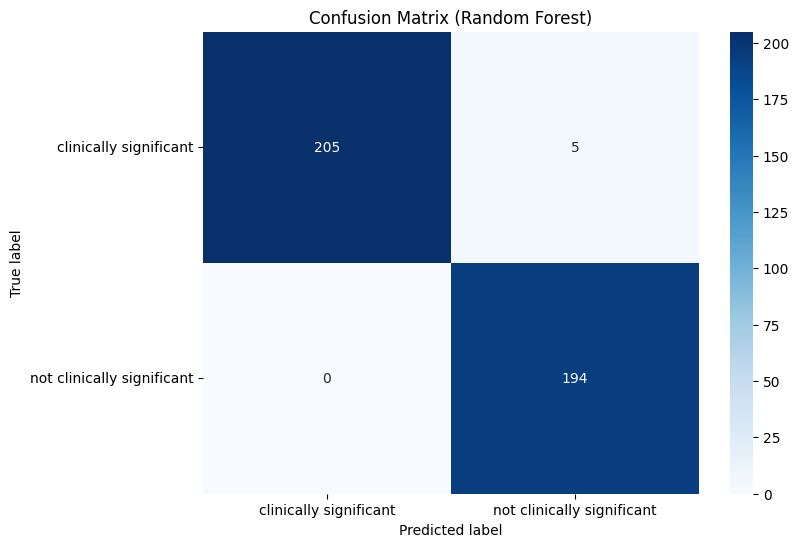

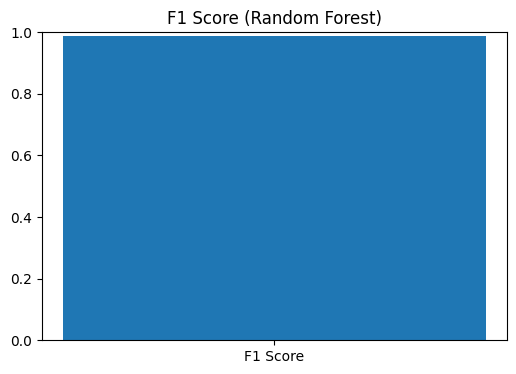

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Set custom labels for the confusion matrix
labels = ['clinically significant', 'not clinically significant']
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels, rotation=0)
plt.show()

# Plot F1 score
plt.figure(figsize=(6, 4))
plt.bar(['F1 Score'], [f1])
plt.ylim(0, 1)
plt.title('F1 Score (Random Forest)')
plt.show()

# IMPROVED RANDOM

In [47]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE


# Hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)

# # Get best model
# best_rf = rf_random.best_estimator_

# # Make predictions
# y_pred = best_rf.predict(X_test_scaled)
# y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]



Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [48]:
# Get best model
best_rf = rf_random.best_estimator_

# Calculate training accuracy
y_train_pred = best_rf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Make predictions on test set
y_test_pred = best_rf.predict(X_test_scaled)
y_test_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print results
print(f"Best Random Forest Parameters: {rf_random.best_params_}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Additional metrics (optional)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f"Test Recall: {test_recall:.4f}")

# ROC AUC (for binary classification)
if len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Training Accuracy: 1.0000
Test Accuracy: 0.9926
Test Precision: 0.9927
Test F1 Score: 0.9926
Test Recall: 0.9926
ROC AUC: 0.9995


Accuracy: 0.9876
F1 Score: 0.9873
Recall: 1.0000
ROC AUC: 0.5118


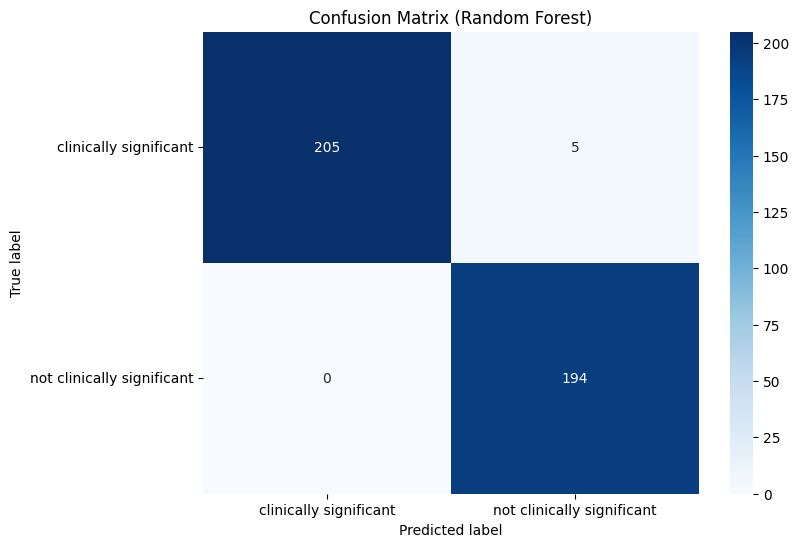

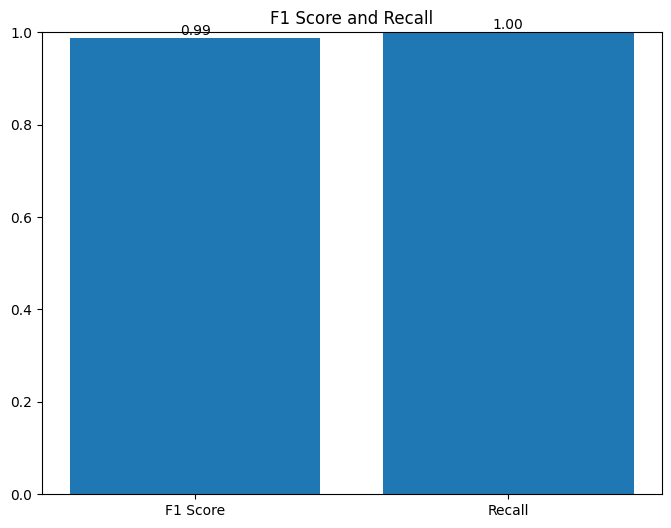

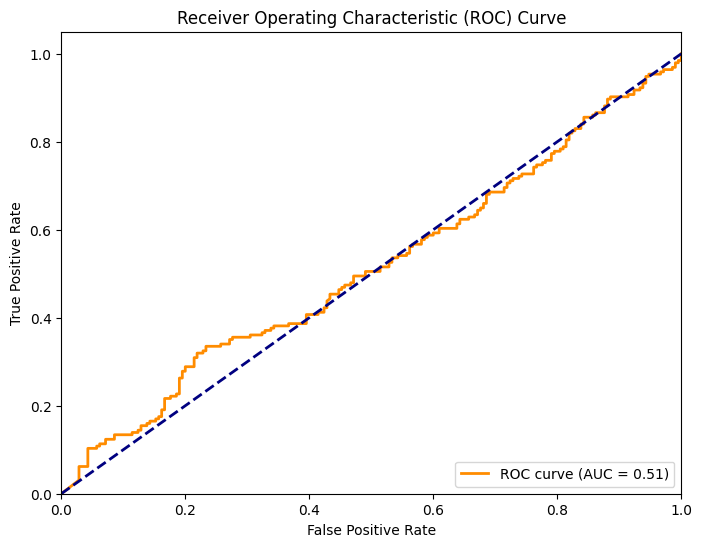

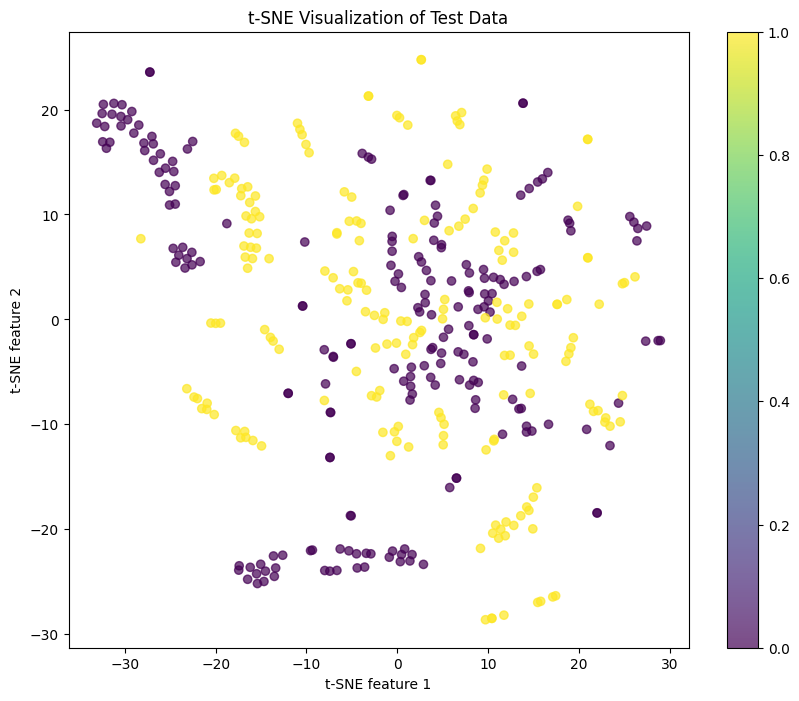

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_lea

In [49]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
labels = ['clinically significant', 'not clinically significant']
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels, rotation=0)
plt.show()

# F1 and Recall Visualization
plt.figure(figsize=(8, 6))
metrics = [f1, recall]
metric_names = ['F1 Score', 'Recall']
plt.bar(metric_names, metrics)
plt.ylim(0, 1)
plt.title('F1 Score and Recall')
for i, v in enumerate(metrics):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Test Data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

# Done